# Simulated data

## Comparing distributions - wrpped functions

In [91]:
import pandas as pd
import numpy as np
from itertools import product
from scipy.special import rel_entr
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
numeric_variable_nums = dict([('boston', 12), ('house',8),('sim_1', 0),('sim_2',0), ('sim_1_tiny',0), ('sim_2_tiny',0), ('sim_m1',1), ('sim_m2',1), ('sim_m3',1), ('sim_m4',1)])

In [2]:
# generate complete data's conditional distributions
def generate_cond(dataset, mr, size, sample_id):
    complete_data_path = '../training_data/samples/' + dataset + '/complete_' + str(mr) + '_' + str(size) + '/sample_' + str(sample_id) + '.csv'
    data = pd.read_csv(complete_data_path, header=None)

    # divide cat/num type
    num_index = list(range(data.shape[1] - numeric_variable_nums[dataset], data.shape[1]))
    cat_index = list(range(0, data.shape[1] - numeric_variable_nums[dataset]))

    # get all possible levels' combination for categorical variable
    all_levels = [np.unique(data.iloc[:,i]).tolist() for i in cat_index]
    all_levels_comb = list(product(*all_levels[:-1]))

    # calculate conditional distributions for complete data
    cond_dist_complete = dict.fromkeys(all_levels_comb, None)
    for index, item in data.iterrows():
        cond = (int(item[0]), int(item[1]), int(item[2]))
        if cond_dist_complete[cond] == None:
            cond_dist_complete[cond] = [0 for x in range(len(all_levels[-1]))]
        cond_dist_complete[cond][int(item[3])] += 1

    for key in cond_dist_complete.keys():
        denom = sum(cond_dist_complete[key])
        cond_dist_complete[key] = [round(x / denom, 3) for x in cond_dist_complete[key]]
    
    pdata = data.copy()
    pdata[3] = np.random.permutation(pdata[3])

    return all_levels, all_levels_comb, cond_dist_complete, pdata

In [3]:
# calculate kl result for permutation data
def perm_kl_result(all_levels, all_levels_comb, cond_dist_complete, perm_data):
    cond_dist_imputed = dict.fromkeys(all_levels_comb, None)
    for index, item in perm_data.iterrows():
            cond = (item[0], item[1], item[2])
            if cond_dist_imputed[cond] == None:
                cond_dist_imputed[cond] = [0 for x in range(len(all_levels[-1]))]
            cond_dist_imputed[cond][int(item[3])] += 1

    for key in cond_dist_imputed.keys():
        denom = sum(cond_dist_imputed[key])
        cond_dist_imputed[key] = [round(x / denom, 3) for x in cond_dist_imputed[key]]

    # output comparing KL divergence
    comparison_dict = dict.fromkeys(all_levels_comb, None)
    for key in comparison_dict.keys():
        if cond_dist_imputed[key] == None:
            continue
        comparison_dict[key] = round(sum(rel_entr(cond_dist_complete[key], cond_dist_imputed[key])),6)
    average_kl = np.average(list(comparison_dict.values()))
    return average_kl, comparison_dict

In [4]:
# output KL divergence for each pair of conditional distribution in one sample
def kl_comparison(method, imputed_data_folder, all_levels, all_levels_comb, cond_dist_complete, sample_id, impute_num):
    # calculate conditional distributions from imputed datasets
    cond_dist_imputed = dict.fromkeys(all_levels_comb, None)
    for i in range(impute_num):
        current_imputed_dir = imputed_data_folder + 'imputed_' + str(sample_id) + '_' + str(i) + '.csv'
        imputed_data = pd.read_csv(current_imputed_dir, header=None)
        for index, item in imputed_data.iterrows():
            if (method == 'cart'):
                item = [int(item[0] - 1), int(item[1] - 1), int(item[2] - 1), int(item[3] - 1)]
            cond = (int(item[0]), int(item[1]), int(item[2]))
            
            if cond_dist_imputed[cond] == None:
                cond_dist_imputed[cond] = [0 for x in range(len(all_levels[-1]))]
            cond_dist_imputed[cond][int(item[3])] += 1

    for key in cond_dist_imputed.keys():
        if cond_dist_imputed[key] == None:
            continue
        denom = sum(cond_dist_imputed[key])
        cond_dist_imputed[key] = [round(x / denom, 3) for x in cond_dist_imputed[key]]

    # output comparing KL divergence
    comparison_dict = dict.fromkeys(all_levels_comb, None)
    for key in comparison_dict.keys():
        if cond_dist_imputed[key] == None:
            continue
        comparison_dict[key] = round(sum(rel_entr(cond_dist_complete[key], cond_dist_imputed[key])),6)
    average_kl = np.average(list(comparison_dict.values()))
    return average_kl, comparison_dict, cond_dist_imputed


In [28]:
# output conditional distribution plots
def cd_plots(cond_dist_complete, cond_dist_imputed, method_list, nrow, ncol, cond = None):
    
    if cond == None:
        x_lab = range(4)
        figure, axes = plt.subplots(nrows=nrow, ncols = ncol, figsize = (15,15))
        axes = axes.reshape(1,-1)
        indx = 0

        for key in cond_dist_complete.keys():
            cond_dist = cond_dist_complete[key]
            compare_data = pd.DataFrame({'Ground Truth': cond_dist})
            for method in method_list:
                imputed_dist = cond_dist_imputed[method][key]
                compare_data[method] = imputed_dist
            compare_data.plot(kind = 'bar', ylim = [0,1], title=str(key), ax = axes[0][indx], legend=False)
            indx += 1
        bar,label = axes[0][0].get_legend_handles_labels()
        figure.legend(bar, label, loc = 'upper right')
        plt.subplots_adjust(hspace=1)
        plt.show()
    
    else:
        x_lab = range(4)
        cond_dist = cond_dist_complete[cond]
        compare_data = pd.DataFrame({'Ground Truth': cond_dist})
        for method in method_list:
            imputed_dist = cond_dist_imputed[method][cond]
            compare_data[method] = imputed_dist
        compare_data = pd.DataFrame({'Ground Truth': cond_dist, 'Imputation': imputed_dist}, 
                                    index=x_lab)
        compare_data.plot(kind = 'bar', ylim = [0,1], title=str(cond))


### sim_1

In [27]:
# complete data
# readin datasets (complete dataset)
dataset = 'sim_1'
mr = 0.3
size = 5000
sample_id = 0
impute_num = 10
all_levels, all_levels_comb, cond_dist_complete, perm_data = generate_cond(dataset, mr, size, sample_id)

In [18]:
# rand result
perm_kl_result(all_levels, all_levels_comb, cond_dist_complete, perm_data)

[1.220069, 0.426697, 0.181805, 0.659439, 0.260634, 0.67118, 0.901205, 0.382857, 0.506973, 0.48859, 0.456542, 0.785712, 0.559643, 0.428726, 0.690983, 0.27329, 0.487196, 1.195497]


(0.5876132222222223,
 {(0.0, 0.0, 0.0): 1.220069,
  (0.0, 0.0, 1.0): 0.426697,
  (0.0, 0.0, 2.0): 0.181805,
  (0.0, 1.0, 0.0): 0.659439,
  (0.0, 1.0, 1.0): 0.260634,
  (0.0, 1.0, 2.0): 0.67118,
  (1.0, 0.0, 0.0): 0.901205,
  (1.0, 0.0, 1.0): 0.382857,
  (1.0, 0.0, 2.0): 0.506973,
  (1.0, 1.0, 0.0): 0.48859,
  (1.0, 1.0, 1.0): 0.456542,
  (1.0, 1.0, 2.0): 0.785712,
  (2.0, 0.0, 0.0): 0.559643,
  (2.0, 0.0, 1.0): 0.428726,
  (2.0, 0.0, 2.0): 0.690983,
  (2.0, 1.0, 0.0): 0.27329,
  (2.0, 1.0, 1.0): 0.487196,
  (2.0, 1.0, 2.0): 1.195497})

In [38]:
# comparison between three methods
method_list = ['gain','cart','vaeac']
average_kl = dict.fromkeys(method_list, None)
comparison_dict = dict.fromkeys(method_list, None)
cond_dist_imputed = dict.fromkeys(method_list, None)

for method in method_list:
    imputed_data_folder = './results/' + dataset + '/MCAR_' + str(mr) + '_' + str(size) + '/' + method + '/'
    result = kl_comparison(method,imputed_data_folder,
                         all_levels, all_levels_comb, cond_dist_complete,
                         sample_id, impute_num)
    average_kl[method], comparison_dict[method], cond_dist_imputed[method] = result

average_kl
    

{'gain': 0.05098988888888889,
 'cart': 0.007968722222222223,
 'vaeac': 0.19053716666666667}

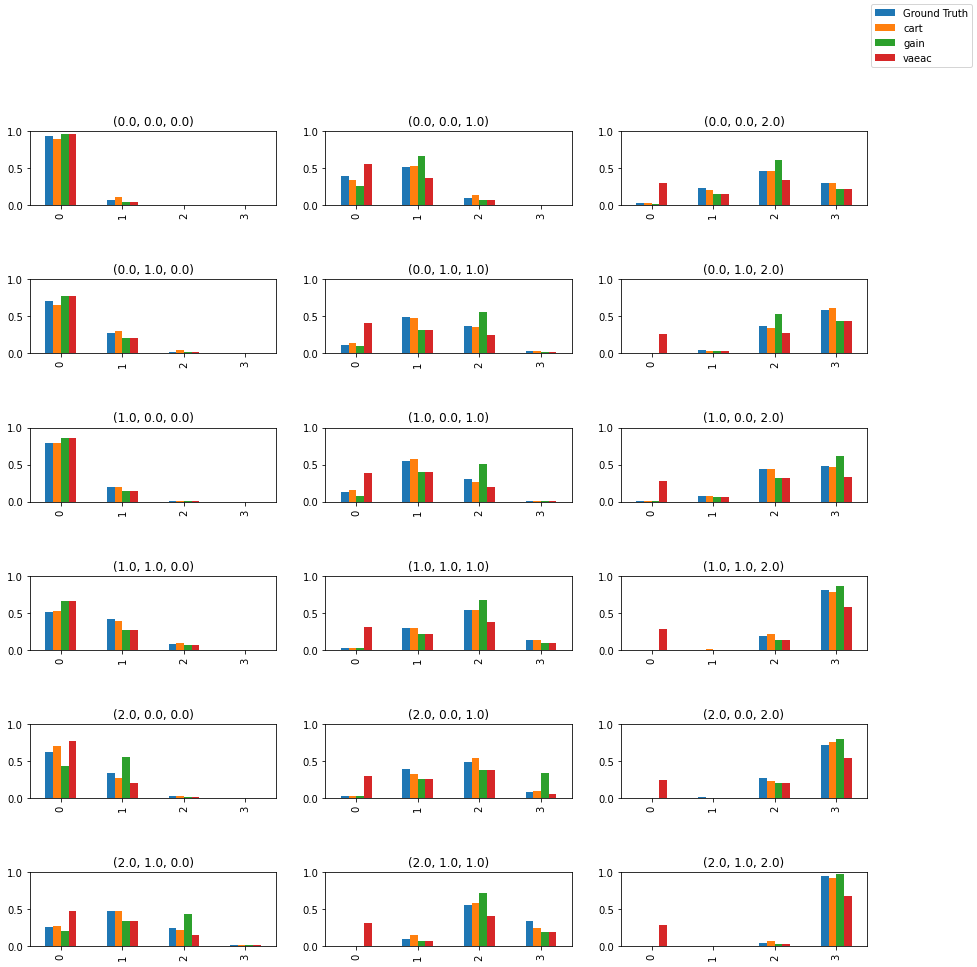

In [39]:
# conditional distributions 
method_list = ['cart','gain','vaeac']
cd_plots(cond_dist_complete, cond_dist_imputed,method_list, 6,3)

In [6]:
# renew VAE's metric
dataset = 'sim_1'
mr = 0.3
size = 5000
sample_id = 0
impute_num = 10
all_levels, all_levels_comb, cond_dist_complete, perm_data = generate_cond(dataset, mr, size, sample_id)

In [7]:
average_kl, comparison_dict = perm_kl_result(all_levels, all_levels_comb, cond_dist_complete, perm_data)
average_kl

0.5966370555555556

In [8]:
method_list = ['vaeac']
average_kl = dict.fromkeys(method_list, None)
comparison_dict = dict.fromkeys(method_list, None)
cond_dist_imputed = dict.fromkeys(method_list, None)

for method in method_list:
    imputed_data_folder = '../training_data/results/' + dataset + '/MCAR_' + str(mr) + '_' + str(size) + '/' + method + '/'
    result = kl_comparison(method,imputed_data_folder,
                         all_levels, all_levels_comb, cond_dist_complete,
                         sample_id, impute_num)
    average_kl[method], comparison_dict[method], cond_dist_imputed[method] = result

print(average_kl)
print(cond_dist_imputed[method].values())

{'vaeac': 0.19053716666666667}
dict_values([[0.955, 0.045, 0.0, 0.0], [0.554, 0.371, 0.075, 0.0], [0.297, 0.152, 0.334, 0.217], [0.776, 0.202, 0.023, 0.0], [0.415, 0.322, 0.243, 0.02], [0.257, 0.03, 0.279, 0.434], [0.853, 0.138, 0.01, 0.0], [0.385, 0.401, 0.204, 0.01], [0.281, 0.062, 0.321, 0.336], [0.661, 0.274, 0.065, 0.0], [0.314, 0.212, 0.376, 0.098], [0.285, 0.0, 0.133, 0.582], [0.771, 0.207, 0.022, 0.0], [0.303, 0.265, 0.379, 0.053], [0.25, 0.003, 0.2, 0.547], [0.48, 0.349, 0.156, 0.015], [0.31, 0.077, 0.414, 0.199], [0.29, 0.0, 0.029, 0.68]])


In [10]:
method_list = ['vaeac']
average_kl = dict.fromkeys(method_list, None)
comparison_dict = dict.fromkeys(method_list, None)
cond_dist_imputed = dict.fromkeys(method_list, None)

for method in method_list:
    imputed_data_folder = '../training_data/results/' + dataset + '/MCAR_' + str(mr) + '_' + str(size) + '/' + method + '/'
    result = kl_comparison(method,imputed_data_folder,
                         all_levels, all_levels_comb, cond_dist_complete,
                         sample_id, impute_num)
    average_kl[method], comparison_dict[method], cond_dist_imputed[method] = result

print(average_kl)
print(cond_dist_imputed[method].values())

{'vaeac': 0.19053716666666667}
dict_values([[0.955, 0.045, 0.0, 0.0], [0.554, 0.371, 0.075, 0.0], [0.297, 0.152, 0.334, 0.217], [0.776, 0.202, 0.023, 0.0], [0.415, 0.322, 0.243, 0.02], [0.257, 0.03, 0.279, 0.434], [0.853, 0.138, 0.01, 0.0], [0.385, 0.401, 0.204, 0.01], [0.281, 0.062, 0.321, 0.336], [0.661, 0.274, 0.065, 0.0], [0.314, 0.212, 0.376, 0.098], [0.285, 0.0, 0.133, 0.582], [0.771, 0.207, 0.022, 0.0], [0.303, 0.265, 0.379, 0.053], [0.25, 0.003, 0.2, 0.547], [0.48, 0.349, 0.156, 0.015], [0.31, 0.077, 0.414, 0.199], [0.29, 0.0, 0.029, 0.68]])


### sim_2

In [22]:
# complete data
# readin datasets (complete dataset)
dataset = 'sim_2'
mr = 0.3
size = 5000
sample_id = 0
impute_num = 10
all_levels, all_levels_comb, cond_dist_complete, perm_data = generate_cond(dataset, mr, size, sample_id)

In [23]:
# rand result
perm_kl_result(all_levels, all_levels_comb, cond_dist_complete, perm_data)

[0.046429, 0.047712, 0.091113, 1.204747, 0.674148, 0.010496, 0.022096, 0.059605, 0.196473, 0.377025, 0.052042, 0.394743, 0.097519, 0.267855, 0.371849, 0.064264, 0.259836, 0.895627]


(0.28519883333333335,
 {(0.0, 0.0, 0.0): 0.046429,
  (0.0, 0.0, 1.0): 0.047712,
  (0.0, 0.0, 2.0): 0.091113,
  (0.0, 1.0, 0.0): 1.204747,
  (0.0, 1.0, 1.0): 0.674148,
  (0.0, 1.0, 2.0): 0.010496,
  (1.0, 0.0, 0.0): 0.022096,
  (1.0, 0.0, 1.0): 0.059605,
  (1.0, 0.0, 2.0): 0.196473,
  (1.0, 1.0, 0.0): 0.377025,
  (1.0, 1.0, 1.0): 0.052042,
  (1.0, 1.0, 2.0): 0.394743,
  (2.0, 0.0, 0.0): 0.097519,
  (2.0, 0.0, 1.0): 0.267855,
  (2.0, 0.0, 2.0): 0.371849,
  (2.0, 1.0, 0.0): 0.064264,
  (2.0, 1.0, 1.0): 0.259836,
  (2.0, 1.0, 2.0): 0.895627})

In [24]:
method_list = ['gain','cart', 'vaeac']
average_kl = dict.fromkeys(method_list, None)
comparison_dict = dict.fromkeys(method_list, None)
cond_dist_imputed = dict.fromkeys(method_list, None)

for method in method_list:
    imputed_data_folder = './results/' + dataset + '/MCAR_' + str(mr) + '_' + str(size) + '/' + method + '/'
    result = kl_comparison(method,imputed_data_folder,
                         all_levels, all_levels_comb, cond_dist_complete,
                         sample_id, impute_num)
    average_kl[method], comparison_dict[method], cond_dist_imputed[method] = result

In [25]:
average_kl

{'gain': 0.07470694444444444,
 'cart': 0.0077919999999999994,
 'vaeac': 0.1528415}

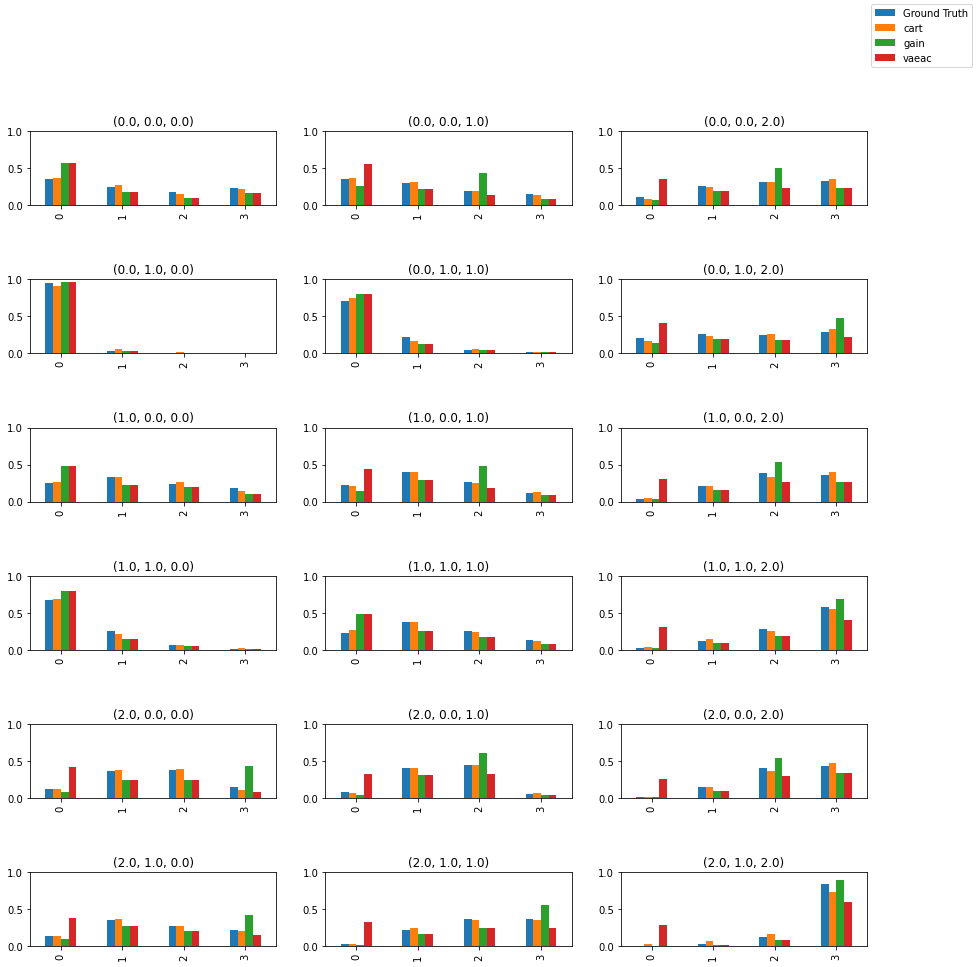

In [26]:
method_list = ['cart','gain', 'vaeac']
cd_plots(cond_dist_complete, cond_dist_imputed,method_list, 6,3)

## x is categorical, y is continuous - wrapped functions

In [214]:
# generate complete data's conditional distributions (x is categorical, y is continuous)
# tag each data piece with corresponding condition
# each value in cond_dist_complete is a dataset

def strint(x):
    return str(int(x))

def generate_cond_cont(dataset, mr, size, sample_id, attn_var, y_loc = 5):
    complete_data_path = '../training_data/samples/' + dataset + '/complete_' + str(mr) + '_' + str(size) + '/sample_' + str(sample_id) + '.csv'
    data = pd.read_csv(complete_data_path, header=None)

    # get all possible levels' combination for categorical variable that we specified
    all_levels = [np.unique(data.iloc[:,i]).tolist() for i in attn_var]
    all_levels_comb = list(product(*all_levels))

    # extract conditional distributions for complete data
    cond_dist_complete = dict.fromkeys(all_levels_comb, None)
    condtag = []
    
    for index, item in data.iterrows():
        cond = '-'.join([strint(item[i]) for i in attn_var])
        condtag.append(cond)
    
    data['cond'] = condtag
    
    for key in all_levels_comb:
        str_key = '-'.join([strint(key[i]) for i in range(len(key))])
        cond_dist_complete[key] = data.loc[data['cond'] == str_key][y_loc].values.tolist()
    
    pdata = data.copy()
    pdata[5] = np.random.permutation(pdata[y_loc])

    return all_levels, all_levels_comb, cond_dist_complete, pdata, condtag

In [98]:
# output MSE/MAE for each pair of specified conditional distribution in one sample
# extract conditional dataset from imputed datasets
def metric_comparison(method, imputed_data_folder, quant_list,
                      all_levels, all_levels_comb, cond_dist_complete, attn_var, condtag,
                      sample_id, impute_num):

    cond_dist_imputed = {key:[] for key in all_levels_comb}
    mse_list = {key:[] for key in all_levels_comb}
    mae_list = {key:[] for key in all_levels_comb}

    for i in range(impute_num):
        current_imputed_dir = imputed_data_folder + 'imputed_' + str(sample_id) + '_' + str(i) + '.csv'
        imputed_data = pd.read_csv(current_imputed_dir, header=None)        
        imputed_data['cond'] = condtag

        for key in all_levels_comb:
            str_key = '-'.join([strint(key[i]) for i in range(len(key))])
            cond_imputed_data = imputed_data.loc[imputed_data['cond'] == str_key][5].values.tolist()
            
            # add data to imputed conditional distribution
            cond_dist_imputed[key] = cond_dist_imputed[key] + cond_imputed_data

            # calculate metrics
            y_true = cond_dist_complete[key]
            mse_list[key].append(mean_squared_error(y_true, cond_imputed_data))
            mae_list[key].append(mean_absolute_error(y_true, cond_imputed_data))

    # calculate average
    mse_quantile = dict.fromkeys(all_levels_comb, None)
    mae_quantile = dict.fromkeys(all_levels_comb, None)
    for key in all_levels_comb:
        mse_quantile[key] = np.quantile(mse_list[key], quant_list)
        mae_quantile[key] = np.quantile(mae_list[key], quant_list)
        
    return cond_dist_imputed, mse_quantile, mae_quantile

In [144]:
# calculate MSE result for permutation data (x is categorical, y is continuous)
def perm_metric_result(all_levels, all_levels_comb, cond_dist_complete, perm_data, attn_var):
    
    cond_dist_imputed = dict.fromkeys(all_levels_comb, None)
    mse_list = dict.fromkeys(all_levels_comb, None)
    mae_list = dict.fromkeys(all_levels_comb, None)
    condtag = []
        
    for index, item in perm_data.iterrows():
        cond = '-'.join([strint(item[i]) for i in attn_var])
        condtag.append(cond)
    
    perm_data['cond'] = condtag

    for key in all_levels_comb:
        str_key = '-'.join([strint(key[i]) for i in range(len(key))])
        cond_imputed_data = perm_data.loc[perm_data['cond'] == str_key][5].values.tolist()
        
        # add data to imputed conditional distribution
        cond_dist_imputed[key] = cond_imputed_data

        # calculate metrics
        y_true = cond_dist_complete[key]
        mse_list[key] = mean_squared_error(y_true, cond_imputed_data)
        mae_list[key] = mean_absolute_error(y_true, cond_imputed_data)
    
    return cond_dist_imputed, mse_list, mae_list

In [275]:
# draw comparing density plots
def cd_density_plots(all_levels_comb, cond_dist_complete, cond_dist_imputed, methods, nrow, ncol):
    
    figure, axes = plt.subplots(nrows=nrow, ncols = ncol, figsize = (15,15))
    axes = axes.reshape(1,-1)
    indx = 0
    colors = {'GT': 'red','gain':'black','cart':'green','vaeac':'blue','gain_qreg':'orange'}
    
    for key in all_levels_comb:
        sns.kdeplot(cond_dist_complete[key], ax = axes[0][indx], color=colors['GT'])
        for method in methods:
            sns.kdeplot(cond_dist_imputed[method][key], ax = axes[0][indx], color = colors[method])
        axes[0][indx].legend(['GT'] + method_list)
        axes[0][indx].set_title(key)
        indx += 1

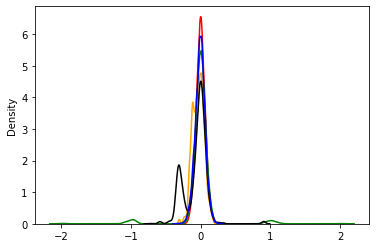

In [277]:
colors = {'GT': 'red','gain':'black','cart':'green','vaeac':'blue','gain_qreg':'orange'}

key = all_levels_comb[0]
sns.kdeplot(cond_dist_complete[key], color=colors['GT'])
for method in method_list:
    sns.kdeplot(cond_dist_imputed[method][key], color = colors[method])

##  sim_m1

M1 - $Y = X_1^2 + \exp(X_2 + X_3/3) + \sin(X_4 + X_5) + \epsilon, \epsilon \sim N(0,1)$

In [259]:
# complete data
# readin datasets (complete dataset)
dataset = 'sim_m1'
mr = 0.3
size = 5000
sample_id = 0
impute_num = 10
attn_var = range(5)
all_levels, all_levels_comb, cond_dist_complete, perm_data, condtag = generate_cond_cont(dataset, mr, size, sample_id, attn_var)

In [247]:
cond_dist_perm, mse_perm, mae_perm = perm_metric_result(all_levels, all_levels_comb, cond_dist_complete, perm_data, attn_var)

col_key = all_levels_comb
mse_avr = [np.average(item) for item in mse_perm.values()]
mae_avr = [np.average(item) for item in mae_perm.values()]
result = pd.DataFrame({'key': col_key, 'mse' :mse_avr, 'mae' : mae_avr})
result.loc['avr'] = result.mean()

result.loc['avr']

key          NaN
mse    20.550402
mae     3.032181
Name: avr, dtype: object

In [257]:
method_list = ['cart','gain_qreg', 'gain', 'vaeac']
quantile_mse = dict.fromkeys(method_list, None)
quantile_mae = dict.fromkeys(method_list, None)
comparison_dict = dict.fromkeys(method_list, None)
cond_dist_imputed = dict.fromkeys(method_list, None)
quant_list = [0.1,0.3,0.5,0.7,0.9,1]

for method in method_list:
    imputed_data_folder = '../training_data/results/' + dataset + '/MCAR_' + str(mr) + '_' + str(size) + '/' + method + '/'
    result = metric_comparison(method,imputed_data_folder, quant_list,
                         all_levels, all_levels_comb, cond_dist_complete, attn_var, condtag,
                         sample_id, impute_num)
    cond_dist_imputed[method], quantile_mse[method], quantile_mae[method] = result

In [249]:
key = all_levels_comb[0]
mse_quantiles = pd.DataFrame({method: quantile_mse[method][key] for method in method_list})
mse_quantiles.index = quant_list
mse_quantiles


,cart,gain_qreg,gain,vaeac
0.1,2.555736,2.630606,10.46237,2.349572
0.3,3.178505,2.633576,10.46237,2.415714
0.5,3.582362,2.634627,10.46237,2.511341
0.7,3.959064,2.635537,10.46237,2.685804
0.9,4.671295,2.636559,10.46237,2.774584
1.0,5.172525,2.640686,10.46237,2.810324


In [226]:
len(all_levels_comb)

15

AttributeError: 'AxesSubplot' object has no attribute 'reshape'

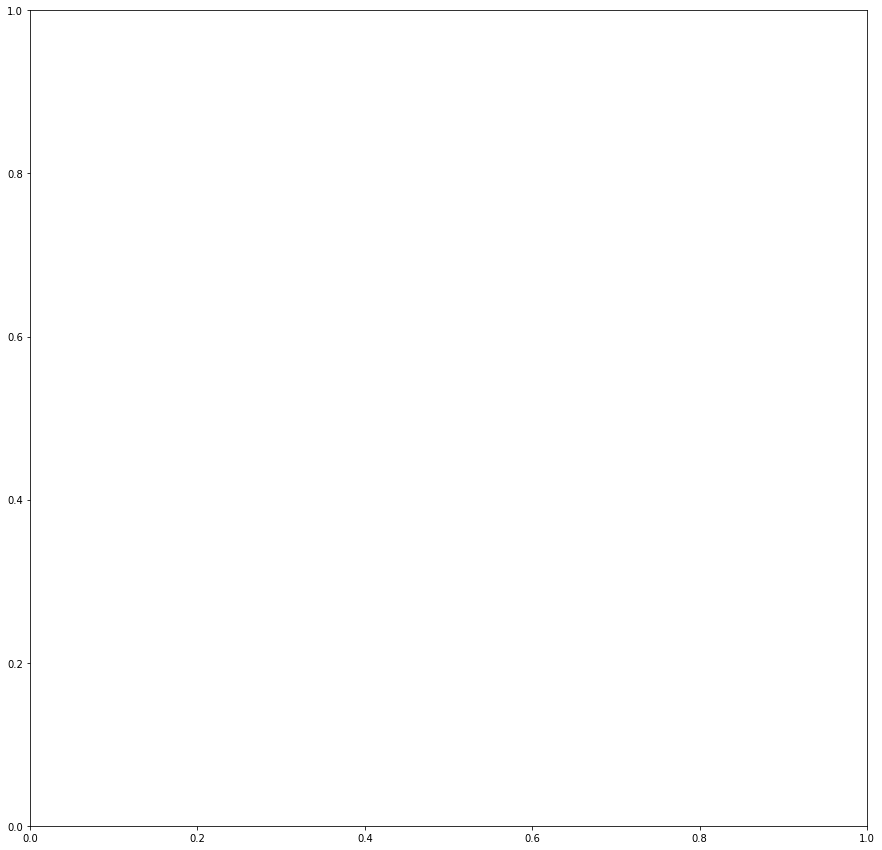

In [276]:
cd_density_plots(all_levels_comb, cond_dist_complete, cond_dist_imputed, method_list, 1,1)

## sim_m2

M2 - $Y = X_1^2 + \exp(X_2 + X_3/3) + X_4 - X_5 + (0.5 + X_2^2/2 + X_5^2/2) \times \epsilon, \epsilon \sim N(0,1)$

In [228]:
# complete data
# readin datasets (complete dataset)
dataset = 'sim_m2'
mr = 0.3
size = 5000
sample_id = 0
impute_num = 10
attn_var = [1,4]
all_levels, all_levels_comb, cond_dist_complete, perm_data, condtag = generate_cond_cont(dataset, mr, size, sample_id, attn_var)

In [229]:
cond_dist_perm, mse_perm, mae_perm = perm_metric_result(all_levels, all_levels_comb, cond_dist_complete, perm_data, attn_var)

col_key = all_levels_comb
mse_avr = [np.average(item) for item in mse_perm.values()]
mae_avr = [np.average(item) for item in mae_perm.values()]
result = pd.DataFrame({'key': col_key, 'mse' :mse_avr, 'mae' : mae_avr})
result.loc['avr'] = result.mean()

result.loc['avr']

key          NaN
mse    28.032336
mae      3.66969
Name: avr, dtype: object

In [230]:
method_list = ['cart','gain_qreg', 'gain', 'vaeac']
quantile_mse = dict.fromkeys(method_list, None)
quantile_mae = dict.fromkeys(method_list, None)
comparison_dict = dict.fromkeys(method_list, None)
cond_dist_imputed = dict.fromkeys(method_list, None)
quant_list = [0.1,0.3,0.5,0.7,0.9,1]

for method in method_list:
    imputed_data_folder = '../training_data/results/' + dataset + '/MCAR_' + str(mr) + '_' + str(size) + '/' + method + '/'
    result = metric_comparison(method,imputed_data_folder, quant_list,
                         all_levels, all_levels_comb, cond_dist_complete, attn_var, condtag,
                         sample_id, impute_num)
    cond_dist_imputed[method], quantile_mse[method], quantile_mae[method] = result

In [231]:
key = all_levels_comb[0]
mse_quantiles = pd.DataFrame({method: quantile_mse[method][key] for method in method_list})
mse_quantiles.index = quant_list
mse_quantiles


,cart,gain_qreg,gain,vaeac
0.1,3.219285,1.630333,1.988798,1.737400
0.3,3.353528,1.630527,1.991802,1.763447
0.5,3.604258,1.630928,1.998026,1.778542
0.7,3.811311,1.630993,1.998623,1.788480
0.9,4.120761,1.631232,2.002626,1.807559
1.0,4.647210,1.631529,2.006897,1.830073


In [232]:
len(all_levels_comb)

6

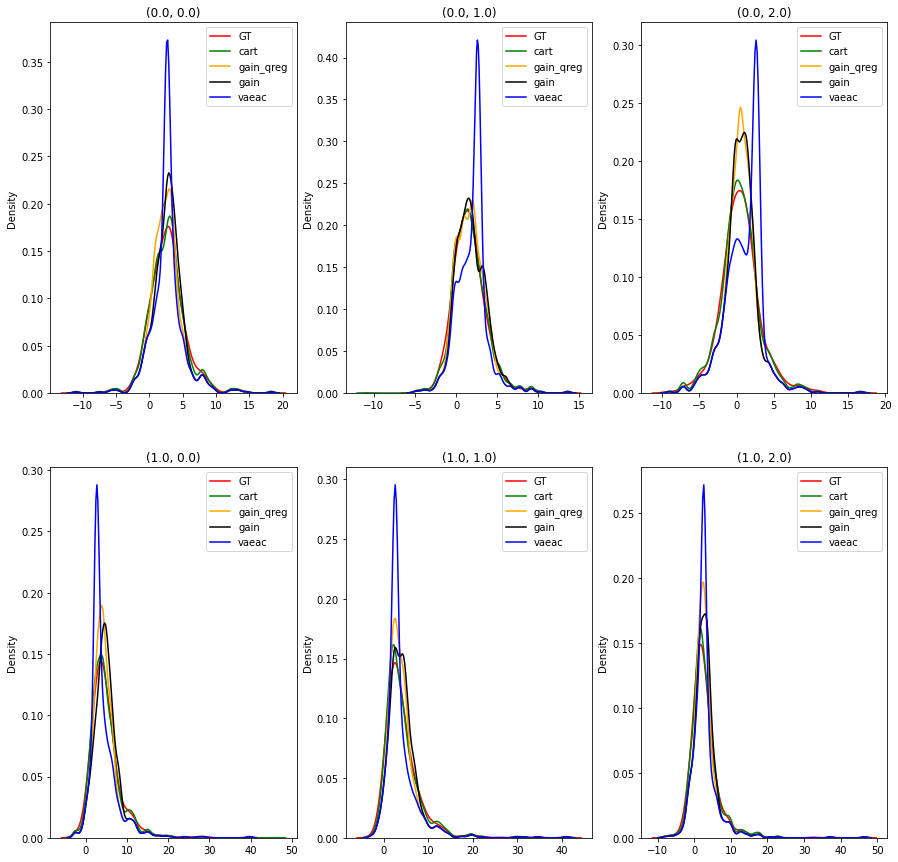

In [233]:
cd_density_plots(all_levels_comb, cond_dist_complete, cond_dist_imputed, method_list, 2, 3)

## sim_m3

M3 - $Y = (5+X_1^2/3 + X_2^2 + X_3^2 + X_4 + X_5) \times \exp(0.5 \times \epsilon), \epsilon \sim \boldsymbol{I}_{U<0.5}\times N(-2,1)+\boldsymbol{I}_{U>0.5} \times N(2,1)$

In [234]:
# complete data
# readin datasets (complete dataset)
dataset = 'sim_m3'
mr = 0.3
size = 5000
sample_id = 0
impute_num = 10
attn_var = [0,1]
all_levels, all_levels_comb, cond_dist_complete, perm_data, condtag = generate_cond_cont(dataset, mr, size, sample_id, attn_var)

In [235]:
cond_dist_perm, mse_perm, mae_perm = perm_metric_result(all_levels, all_levels_comb, cond_dist_complete, perm_data, attn_var)

col_key = all_levels_comb
mse_avr = [np.average(item) for item in mse_perm.values()]
mae_avr = [np.average(item) for item in mae_perm.values()]
result = pd.DataFrame({'key': col_key, 'mse' :mse_avr, 'mae' : mae_avr})
result.loc['avr'] = result.mean()

result.loc['avr']

key           NaN
mse    474.679903
mae     14.240662
Name: avr, dtype: object

In [236]:
method_list = ['cart','gain_qreg', 'gain', 'vaeac']
quantile_mse = dict.fromkeys(method_list, None)
quantile_mae = dict.fromkeys(method_list, None)
comparison_dict = dict.fromkeys(method_list, None)
cond_dist_imputed = dict.fromkeys(method_list, None)
quant_list = [0.1,0.3,0.5,0.7,0.9,1]

for method in method_list:
    imputed_data_folder = '../training_data/results/' + dataset + '/MCAR_' + str(mr) + '_' + str(size) + '/' + method + '/'
    result = metric_comparison(method,imputed_data_folder, quant_list,
                         all_levels, all_levels_comb, cond_dist_complete, attn_var, condtag,
                         sample_id, impute_num)
    cond_dist_imputed[method], quantile_mse[method], quantile_mae[method] = result

In [237]:
key = all_levels_comb[0]
mse_quantiles = pd.DataFrame({method: quantile_mse[method][key] for method in method_list})
mse_quantiles.index = quant_list
mse_quantiles


,cart,gain_qreg,gain,vaeac
0.1,136.338398,87.698184,76.394451,84.012350
0.3,145.491347,87.700470,76.429571,84.334407
0.5,152.157896,87.702284,76.456534,84.406542
0.7,158.623755,87.706025,76.464901,84.813476
0.9,167.048154,87.710631,76.477422,86.262005
1.0,178.482407,87.712780,76.478654,86.469856


In [238]:
len(all_levels_comb)

6

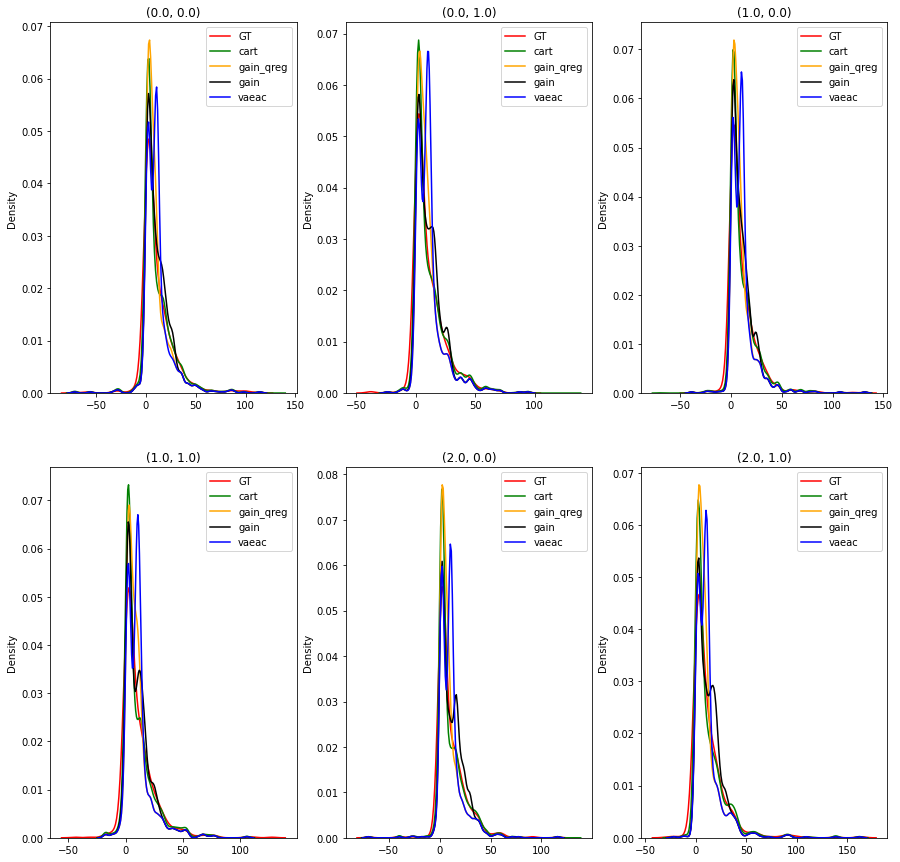

In [239]:
cd_density_plots(all_levels_comb, cond_dist_complete, cond_dist_imputed, method_list, 2, 3)

## sim_m4

M4 - $Y = \boldsymbol{I}_{u<0.5}\times N(-X_1, 0.25^2) + \boldsymbol{I}_{u>0.5}\times N(X_1, 0.25^2)$

In [266]:
# complete data
# readin datasets (complete dataset)
dataset = 'sim_m4'
mr = 0.3
size = 5000
sample_id = 0
impute_num = 10
attn_var = [0]
all_levels, all_levels_comb, cond_dist_complete, perm_data, condtag = generate_cond_cont(dataset, mr, size, sample_id, attn_var)

In [262]:
cond_dist_perm, mse_perm, mae_perm = perm_metric_result(all_levels, all_levels_comb, cond_dist_complete, perm_data, attn_var)

col_key = all_levels_comb
mse_avr = [np.average(item) for item in mse_perm.values()]
mae_avr = [np.average(item) for item in mae_perm.values()]
result = pd.DataFrame({'key': col_key, 'mse' :mse_avr, 'mae' : mae_avr})
result.loc['avr'] = result.mean()

result.loc['avr']

key         NaN
mse     3.38651
mae    1.479655
Name: avr, dtype: object

In [272]:
method_list = ['cart','gain_qreg', 'gain', 'vaeac']
quantile_mse = dict.fromkeys(method_list, None)
quantile_mae = dict.fromkeys(method_list, None)
comparison_dict = dict.fromkeys(method_list, None)
cond_dist_imputed = dict.fromkeys(method_list, None)
quant_list = [0.1,0.3,0.5,0.7,0.9,1]

for method in method_list:
    imputed_data_folder = '../training_data/results/' + dataset + '/MCAR_' + str(mr) + '_' + str(size) + '/' + method + '/'
    result = metric_comparison(method,imputed_data_folder, quant_list,
                         all_levels, all_levels_comb, cond_dist_complete, attn_var, condtag,
                         sample_id, impute_num)
    cond_dist_imputed[method], quantile_mse[method], quantile_mae[method] = result

In [274]:
key = all_levels_comb[0]
mse_quantiles = pd.DataFrame({method: quantile_mse[method][key] for method in method_list})
mse_quantiles.index = quant_list
mse_quantiles


,cart,gain_qreg,gain,vaeac
0.1,0.048099,0.006292,0.030402,0.003288
0.3,0.051805,0.006319,0.030447,0.003384
0.5,0.054270,0.006332,0.030546,0.003586
0.7,0.057668,0.006340,0.030647,0.003659
0.9,0.059004,0.006344,0.030708,0.003845
1.0,0.059910,0.006346,0.030872,0.003898


KeyError: 0.0

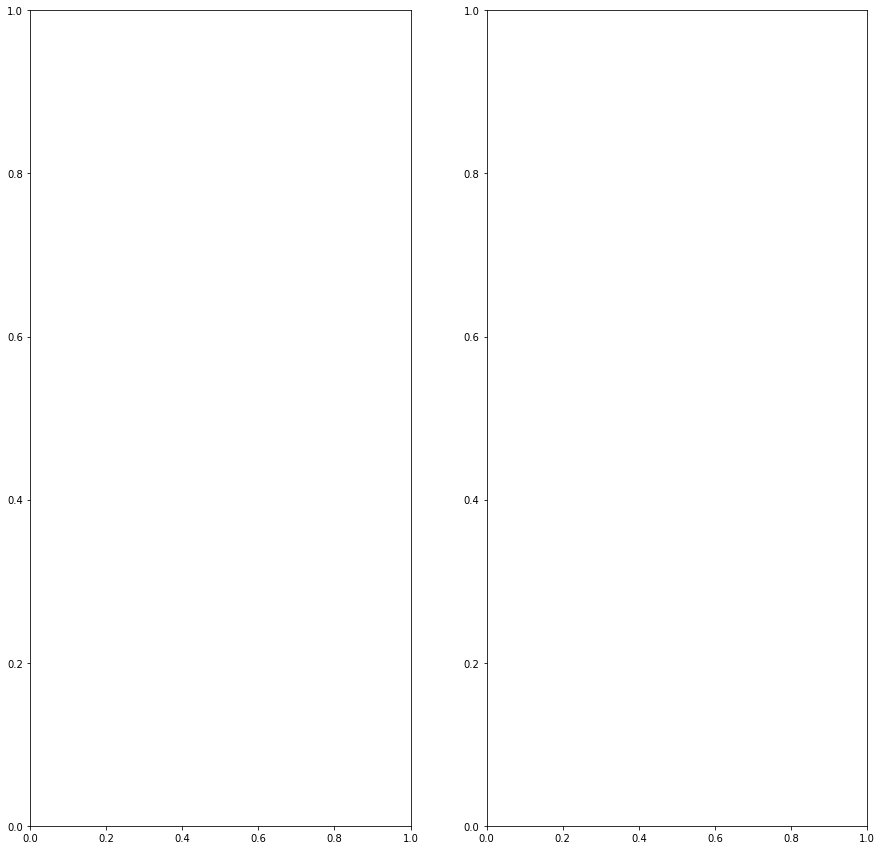

In [271]:
cd_density_plots(all_levels_comb, cond_dist_complete, cond_dist_imputed, method_list, 1, 2)

# ACS data

## build income data set

In [ ]:
import pandas as pd
import numpy as np
import itertools
data = pd.read_csv('./data/house.csv')

In [2]:
cols = data.columns
corr_val = dict()
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        corr_val[(cols[i], cols[j])] = np.corrcoef(data[cols[i]], data[cols[j]])[0][1]

In [3]:
corr_list = [item for item in sorted(corr_val.items(), key = lambda x:x[1]) if 'WAGP' in item[0]]

In [4]:
simp_cols = list(set([x[0] for x in corr_list[:10]]).union(set([x[0] for x in corr_list[-10:]])))
simp_collist = list(set(list(itertools.chain(*simp_cols))))
simp_collist

['WIF',
 'PRIVCOV',
 'LAPTOP',
 'HINS1',
 'R65',
 'JWTR',
 'COW',
 'HUPAOC',
 'JWRIP',
 'AGEP',
 'DIS',
 'PUBCOV',
 'HUPARC',
 'HINS3',
 'PAOC',
 'TEN',
 'WKHP',
 'SCHL',
 'WAGP',
 'JWMNP',
 'SEX']

In [5]:
data_simp = data[simp_collist]

In [ ]:
data_simp.to_csv('./data/income.csv', sep = ',', header=True, index=False)

## Income dataset

In [3]:
import pandas as pd
import numpy as np

In [4]:
data = pd.read_csv('./data/income.csv')

In [10]:
[np.unique(item) for name,item in data.iteritems()]

[array([0, 1, 2, 3], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1, 2], dtype=int64),
 array([0, 1, 2], dtype=int64),
 array([0, 1, 2, 3], dtype=int64),
 array([0, 1, 2, 3], dtype=int64),
 array([0, 1, 2], dtype=int64),
 array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
        66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
        83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96],
       dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1, 2, 3], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1, 2], dtype=int64),
 array([0, 1, 2], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 